In [1]:
import pystan
import numpy as np

In [17]:
ICUH_code = """
data {
    int T;
    int YIC[T];
    int YH[T];
    int spd;
    int begin;
    real N;
    real sgm;
    real gmm;
    vector[10] fHtoIC;
    vector[T] zetaHt;
    vector[10] fEtoH;
    vector[T] zetaICt;
    
    
    
}
transformed data {
    int end = T*7*spd;
    real dt = 1.0/spd;
    int sizemat = ((end-begin)*spd)+ 1;

}
parameters {
    real<lower=0> beta;
    real Tx_pi;
    real Tx_iota;
    
    real Tx_kappa;
    real<lower=0,upper=1> pIC;
    real<lower=0> etaIC;
    real<lower=0,upper=1> pH;
    real<lower=0> etaH;    
    
}
transformed parameters {
    real mat[sizemat,7];
    vector[T] NNI;
    vector[T] NIC;
    vector[T] NNH;
    vector[T] NH;    
    vector[T] sizeICs;
    vector[T] sizeHs;
    
    real time = begin;
    real boolK = 0;
    real cumIC = 0;
    real cumH = 0;
    
    real<lower=0,upper=1> pi = exp(Tx_pi)/(exp(Tx_pi)+1);
    real<lower=0> iota = exp(Tx_iota)/((exp(Tx_pi)+1)*(exp(Tx_iota)+1));
    real<lower=-1> kappa = exp(Tx_kappa) - 1;
    
    mat[1,1]=time;
    mat[1,2]=(1-pi-iota)*N; 
    mat[1,3]=(iota/4)*N;
    mat[1,4]=(iota/4)*N;
    mat[1,5]=(iota/4)*N;
    mat[1,6]=(iota/4)*N;
    mat[1,7]=pi*N; 
    
    if ( (pi+iota<1)||(beta>=0)||(kappa>=-1)||(pIC<=1)||(pIC>=0)||(etaIC>=1)||(pH<=1)||(pH>=0)||(etaH>=1))
    {
        for (t in 2:sizemat)
        {
            if (((time>=19)&&(time<=28))||((time>=75)&&(time<=92))||
              ((time>=131)&&(time<=140))||((time>=179)&&(time<=196)))
              {
                boolK=1;
              }
            else {boolK=0;}
            mat[t,2] = mat[t-1,2] - dt*beta*(boolK*kappa+1)*mat[t-1,2]*((mat[t-1,5]+mat[t-1,6])/N);
            mat[t,3] = mat[t-1,3] + dt*beta*(boolK*kappa+1)*mat[t-1,2]*((mat[t-1,5]+mat[t-1,6])/N) - dt*sgm*mat[t-1,3];
            mat[t,4] = mat[t-1,4] + dt*sgm*mat[t-1,3] - dt*sgm*mat[t-1,4];
            mat[t,5] = mat[t-1,5] + dt*sgm*mat[t-1,4] - dt*gmm*mat[t-1,5];
            mat[t,6] = mat[t-1,6] + dt*gmm*mat[t-1,5] - dt*gmm*mat[t-1,6];
            mat[t,7] = mat[t-1,7] + dt*gmm*mat[t-1,7];
            time = begin + (t-1)*dt;
            mat[t,1] = time;
        }
        // number of new detected Hospital admissions obtained via convolution
        for (s in 1:T)
        {
            NNI[s] = mat[s*7*spd,2] - mat[(s+1)*7*spd,2];
        }

        for (s in 1:T)
        {
            cumH=0;
            
            for (r in 1:min(s,10))
            {
              cumH += NNI[s-r+1]*fEtoH[r];  
            }
            NH[s] = cumH*zetaHt[s]*pH ;  
            NNH[s] = cumH*pH ;
        }  
        sizeHs = NH/(etaH-1);
        
        // number of new detected IC admissions obtained via convolution
        
        for (s in 1:T)
        {
            cumIC=0;
            
            for (r in 1:min(s,10))
            {
              cumIC += NNH[s-r+1]*fHtoIC[r];  
            }
            NIC[s] = cumIC*zetaICt[s]*pIC;    
        }  
        sizeICs = NIC/(etaIC-1);
    }

}
model {


    if( (pi+iota>=1)||(beta<=0)||(kappa<=-1)||(pIC>=1)||(pIC<=0)||(pH>=1)||(pH<=0)||(etaIC<=1)||(etaH<=1))
    {
        target += negative_infinity();
    }
    else
    {
        target += normal_lpdf(beta|0.0,1.0);//uniform_lpdf(beta|0.0,4.0);
        
        target += beta_lpdf(pi|37.5,62.5) + uniform_lpdf(iota|0.0, 0.1)
                 + ((Tx_pi)-2*log((1+exp(Tx_pi)))) 
                 + ((Tx_iota)-(2*log(1+exp(Tx_iota))+log(1+exp(Tx_pi)))) ;
                 
        target += uniform_lpdf(iota|0., 1e-1)
                + ((Tx_iota)-(2*log(1+exp(Tx_iota))+log(1+exp(Tx_pi))));
                
        target += normal_lpdf(Tx_kappa|0.0,1.0); //std_normal() ?
        
        target += beta_lpdf(pIC|1.0, 2.0);//uniform_lpdf(pIC|0.0,1.0);
        
        target += gamma_lpdf(etaIC|2, 0.1);//uniform_lpdf(etaIC|1.0,100.0);
        
        target += beta_lpdf(pH|1.0, 2.0);//uniform_lpdf(pH|0.0,1.0);
        
        target += gamma_lpdf(etaH|2, 0.1);//uniform_lpdf(etaH|1.0,100.0);   
        
        // Likelihood of hospitalisation data
        for (s in 1:T)
        {
            
            if((sizeHs[s]==0) && (YH[s]!=0))
            {
                target += negative_infinity();
            }
            else if ((sizeHs[s]==0) && (YH[s]==0))
            {
                target += 0.0;
            }
            else
            {
                target += neg_binomial_2_lpmf(YH[s]| NH[s], sizeHs[s]);// Don't forget to vectorise
            }
        }
        
        // Likelihood of ICU admission data
        for (s in 1:T)
        {
            
            if((sizeICs[s]==0) && (YIC[s]!=0))
            {
                target += negative_infinity();
            }
            else if ((sizeICs[s]==0) && (YIC[s]==0))
            {
                target += 0.0;
            }
            else
            {
                target += neg_binomial_2_lpmf(YIC[s]| NIC[s], sizeICs[s]);// Don't forget to vectorise
            }
        }        
    }
    
}
"""

In [18]:
sm = pystan.StanModel(model_code=ICUH_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4a1567b5415022525b4be3bf785b9132 NOW.


In [19]:
True_params = [0.53, 0.30, 0.00001, 0.4, 0.07, 15, 0.0008, 25]

y = np.loadtxt('ICUsimData.txt', dtype=int)
ICU_data = {'T': int(33), 'YIC': y[33:],'YH': y[:33] ,'spd': int(4), 'begin': int(0), 'N': 55268100, 'sgm': 1.0, 'gmm': 0.52,
            'fEtoH': [0.893541496,0.095125091,0.010126875,
                        0.001078092,0.000114772,0.000012218,
                        0.000001301,0.000000138,0.000000015,
                        0.000000002],
            'fHtoIC': [0.939189937,0.057112199,0.003472996,
                         0.000211193,0.000012843,0.000000781,
                         0.000000047,0.000000003,0.000000000,
                         0.000000000],
            'zetaHt': [0.23, 0.23, 0.24, 0.23, 0.19, 0.21,
                           0.20, 0.201, 0.202, 0.202, 0.203, 0.20,
                           0.193, 0.195, 0.199, 0.2, 0.19, 0.89,
                           0.21, 0.20, 0.21, 0.20, 0.20, 0.20,
                           0.22, 0.20, 0.201, 0.20, 0.203, 0.20,
                           0.21, 0.20, 0.20],
            'zetaICt': [0.89, 0.89, 0.89, 0.89, 0.89, 0.89,
                         0.83, 0.75, 0.83, 0.89, 0.89, 0.89,
                         0.89, 0.89, 0.89, 0.89, 0.89, 0.89,
                         0.89, 0.89, 0.89, 0.89, 0.89, 0.89,
                         0.89, 0.89, 0.88, 0.8, 0.74, 0.89,
                         0.89, 0.86, 0.74] 
            }

def transform_from_constraint(Utx_pars):
    tx_pi    = np.log( Utx_pars[0]/(1 - Utx_pars[0]) )
    tx_iota  = np.log( Utx_pars[1]/(1 - (Utx_pars[0] + Utx_pars[1]) ) )
    tx_kappa = np.log(Utx_pars[2]+1)
    return tx_pi, tx_iota, tx_kappa
init_pi1, init_iota1, init_kappa1 = transform_from_constraint([0.53,0.0000061,0.12])
init_pi2, init_iota2, init_kappa2 = transform_from_constraint([0.56,0.0000081,0.1])

init_chains =[dict(beta=0.16,pi=init_pi1,iota=init_iota1,kappa=init_kappa1,pIC=0.00078,etaIC=10.0,pH=0.00078,etaH=10.0),
             dict(beta=0.18,pi=init_pi2,iota=init_iota2,kappa=init_kappa2,pIC=0.00058,etaIC=12.0,pH=0.00058,etaH=12.0)]
fit = sm.sampling(data=ICU_data, warmup=1000,iter=2000, control={'adapt_delta':0.9}, init=init_chains, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [23]:
params=np.zeros((1000,8))
params[:,0]=fit['beta']
params[:,1]=fit['pi']
params[:,2]=fit['iota']
params[:,3]=fit['kappa']
params[:,4]=fit['pIC']
params[:,5]=fit['etaIC']
params[:,6]=fit['pH']
params[:,7]=fit['etaH']

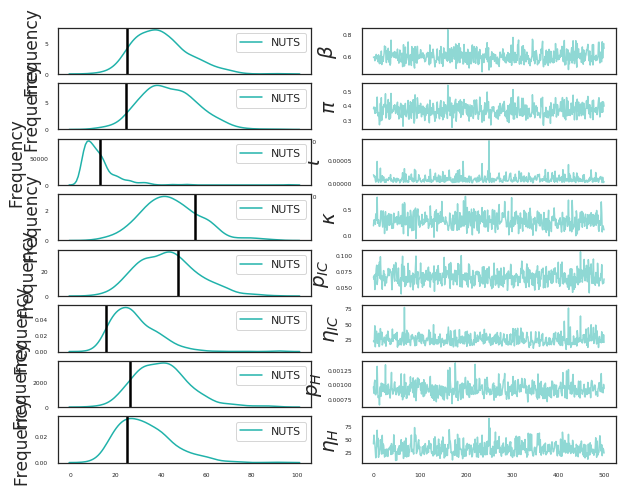

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(10,8),"font.size":10,"axes.titlesize":20,"axes.labelsize":17,
           "xtick.labelsize":6, "ytick.labelsize":6},style="white")
param_names = [r"$\beta$", r"$\pi$", r"$\iota$", r"$\kappa$", r"$p_{IC}$", r"$\eta_{IC}$", r"$p_{H}$", r"$\eta_{H}$"]
T_lines = [0.53, 0.30, 0.00001, 0.4, 0.07, 15, 0.0008, 25]
for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(8, 2, 1 + 2 * i)
        plt.ylabel('Frequency')
        sns.kdeplot(params[:, i], color='lightseagreen', legend=True, label='NUTS')

        plt.axvline(T_lines[i], linewidth=2.5, color='black')
        if i==0:
                plt.legend()

        # Add trace subplot
        plt.subplot(8, 2, 2 + 2 * i)
        plt.ylabel(p, fontsize=20)  
        plt.plot(params[:, i], alpha=0.5, color='lightseagreen')


In [26]:
fit.to_dataframe(permuted=False,inc_warmup=False,diagnostics =True)

,chain,draw,warmup,beta,Tx_pi,Tx_iota,Tx_kappa,pIC,etaIC,pH,...,pi,iota,kappa,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,0.637237,-0.340406,-11.102344,0.239284,0.053953,17.969694,0.001015,...,0.415711,0.000009,0.270340,-216.999138,0.996059,2.707894e-02,6,63,0,222.121831
1,0,1,0,0.570298,-0.588811,-10.902465,0.243608,0.071492,37.214075,0.000914,...,0.356908,0.000012,0.275843,-218.884087,0.891011,2.707894e-02,8,255,0,221.291327
2,0,2,0,0.523546,-0.696692,-10.474911,0.387794,0.083129,26.380438,0.000754,...,0.332546,0.000019,0.473726,-222.673140,0.993982,2.707894e-02,7,127,0,225.129749
3,0,3,0,0.520163,-0.805107,-10.978186,0.345307,0.075507,17.067278,0.000772,...,0.308934,0.000012,0.412423,-218.944795,0.989047,2.707894e-02,7,127,0,224.531730
4,0,4,0,0.583780,-0.672888,-11.736265,0.209696,0.072479,30.889254,0.000797,...,0.337850,0.000005,0.233303,-217.119726,0.999791,2.707894e-02,7,127,0,222.349090
5,0,5,0,0.654396,-0.524295,-12.051766,0.054884,0.082115,28.285272,0.000818,...,0.371849,0.000004,0.056418,-219.130072,0.800117,2.707894e-02,7,127,0,223.109327
6,0,6,0,0.572928,-0.419529,-10.448421,0.413630,0.050079,16.175149,0.001186,...,0.396629,0.000017,0.512298,-219.927287,0.996576,2.707894e-02,7,191,0,222.573492
7,0,7,0,0.704553,-0.246860,-11.925743,0.163050,0.093556,44.176221,0.000905,...,0.438597,0.000004,0.177096,-221.255794,0.997801,2.707894e-02,7,127,0,225.546971
8,0,8,0,0.633744,-0.340306,-9.960681,0.074211,0.073461,25.951767,0.000880,...,0.415735,0.000028,0.077034,-221.833662,0.985201,2.707894e-02,7,127,0,226.541263
9,0,9,0,0.592546,-0.535503,-10.775582,0.164192,0.078763,36.078544,0.000894,...,0.369234,0.000013,0.178440,-218.343045,0.921450,2.707894e-02,7,127,0,224.875902


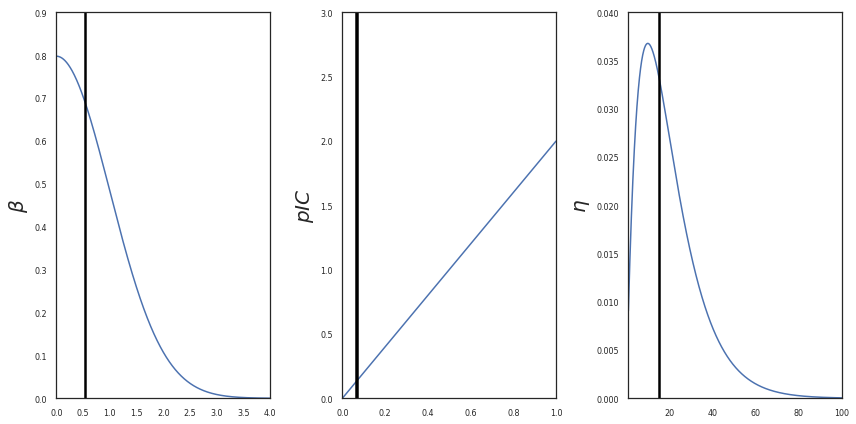

In [28]:
import scipy.stats as stats
import seaborn as sns
sns.set_context("paper", font_scale=3)
sns.set(rc={"figure.figsize":(12,6),"font.size":10,"axes.titlesize":20,"axes.labelsize":17,
           "xtick.labelsize":8, "ytick.labelsize":8},style="white")
param_names = [r"$\beta$", r"$\pi$", r"$iota$", r"$\kappa$", r"$pIC$", r"$\eta$"]#
l=np.linspace(0,4,1000)
plt.subplot(131)
plt.plot(l,stats.halfnorm(0,1).pdf(l))
plt.axvline(T_lines[0], linewidth=2.5, color='black')
plt.ylabel(param_names[0], fontsize=20)
plt.xlim([0,4])
plt.ylim([0,0.9])
l=np.linspace(0,1,1000)
plt.subplot(132)
plt.plot(l,stats.beta(2,1).pdf(l))
plt.axvline(T_lines[4], linewidth=3.5, color='black')
plt.ylabel(param_names[4], fontsize=20)
plt.xlim([0,1])
plt.ylim([0,3])
l=np.linspace(1,100,1000)
plt.subplot(133)
plt.plot(l,stats.gamma.pdf(l,2,scale=10))
plt.axvline(T_lines[5], linewidth=2.5, color='black')
plt.ylabel(param_names[5], fontsize=20)
plt.xlim([1,100])
plt.ylim([0,0.04])
plt.tight_layout()